## HW5 logistic_regression（逻辑回归作业练习）

### <font color=brown> 本次作业包括两个练习</font>
### 练习1: 使用逻辑回归模型来对学生是否能被大学录取进行预测。
### 已知数据集中包含两次测试成绩exam1 和 exam2，以及是否被录取的标记 admitted。

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report #这个包是评价报告
%matplotlib inline
plt.style.use('fivethirtyeight')

### 1.1 准备数据

In [77]:
print("201250182 郑义")  #  双引号内替换成你的学号和姓名
data = pd.read_csv('hw5data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()#看前五行

201250182 郑义


,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [78]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


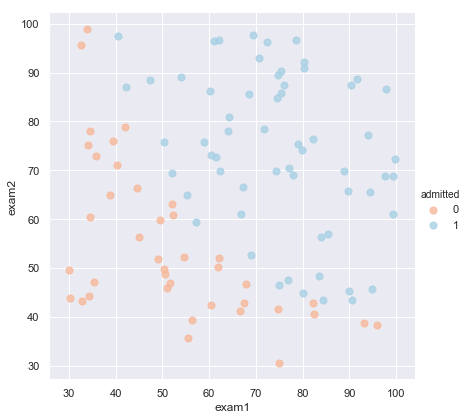

In [79]:
# 关于 SeaBorn 画图，可参考：https://www.jianshu.com/p/5ff47c7d0cc9

sns.set(context="notebook", style="darkgrid", color_codes=False, palette=sns.color_palette("RdBu", 2))

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           height=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )
plt.show()  #看一下数据的样子

In [80]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))}) # ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)            # 合并数据，根据列合并
    return data.iloc[:, :-1].values                 # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])                # df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())  # 特征缩放

In [122]:
X = get_X(data)
print(X.shape)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


### 1.2 sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 


In [123]:
## 实现sigmoid 函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))                              ## 补充YOUR_CODE处的代码

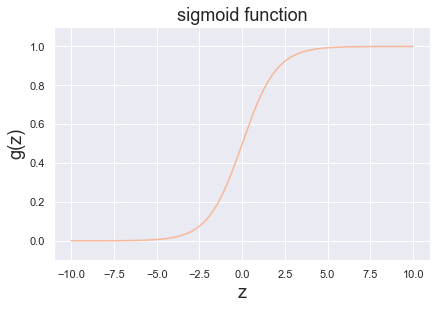

In [124]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01)))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

### 1.3 cost function(交叉熵代价函数)
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$


In [125]:
theta = np.zeros(3) # X(m*n) so theta is n*1
theta

array([0., 0., 0.])

In [100]:
## 实现代价函数 cost
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    fst = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    scd = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    
    return np.sum(fst - scd) / (len(X))                               ## 补充YOUR_CODE处的代码

# X @ theta与X.dot(theta)等价

In [101]:
cost(theta, X, y)

69.31471805599453

### 1.4 gradient 函数(梯度函数)
* 梯度计算$\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [141]:
## 实现梯度计算函数 gradient
def gradient(theta, X, y):
    y = np.matrix(y)
    
    error = (sigmoid(X * theta.T) - y.T)
    grad = np.sum(np.dot(X.T, error)) / len(X)
    
    return grad

In [142]:
gradient(theta, X, y)

-70.11617638441423

### 1.5 拟合参数
* <font color=Brow>这里我们不使用梯度下降法，改用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去计算参数</font>  


In [143]:
import scipy.optimize as opt

In [144]:
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [145]:
print(res)

NameError: name 'res' is not defined

### 1.6 用训练集预测和验证

In [146]:
## 回忆课堂内容，此处的概率如何计算
def predict(x, theta):
    
    prob =                             ## 补充YOUR_CODE处的代码
    return (prob >= 0.5).astype(int)

SyntaxError: invalid syntax (<ipython-input-146-6207d85e06bf>, line 4)

In [147]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))
## 此处的classification_report函数将根据真值y与预测值y_pred，输出分析报告

NameError: name 'res' is not defined

### 1.7 寻找决策边界

* $\theta^T x = 0$ (一个样本$x$)
* $X \theta = 0$ (所有训练样本$X$)

In [148]:
print(res.x) # this is final theta
res.x[2]

NameError: name 'res' is not defined

In [149]:
#YOUR_CODE begin
    #此处补充4~5行代码，计算x和y的值，用于绘制决策边界
#YOUR_CODE end

In [150]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


NameError: name 'x' is not defined

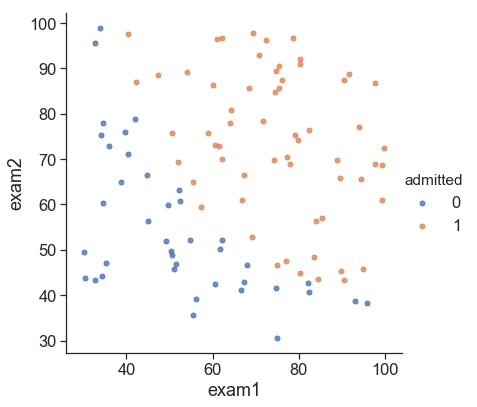

In [151]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           height=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

## 2 正则化逻辑回归
### 练习2: 使用正则化逻辑回归模型来对芯片是否能通过质检进行预测。
### 已知数据集中包含两次检测成绩test1 和 test2，以及是否通过质检的标记 accepted。
### 2.1 准备数据

In [152]:
df = pd.read_csv('hw5data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


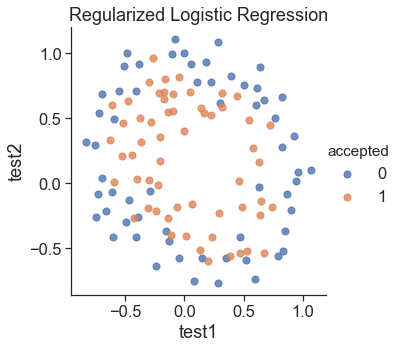

In [153]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           height=5, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

### 2.2 feature mapping（特征映射）

* 我们进行多项式扩展来构造特征
polynomial expansion

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```
<img style="float: left;" src="mapped_feature.png">

In [154]:
def feature_mapping(x, y, power, as_ndarray=False):
    #     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)


In [155]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)

In [156]:
data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [157]:
data.describe()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,...,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,...,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,...,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,...,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,...,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646562,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,...,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,...,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


### 2.3 regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [158]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [159]:
## 实现正则化代价函数
def regularized_cost(theta, X, y, lambd=1):
#YOUR_CODE begin
    fst = cost(theta, X, y)
    scd = theta.T^2
    total = np.sum(scd) * lambd / (2 * len(X))
    
    return fst + total
#YOUR_CODE end
#正则化代价函数

In [160]:
regularized_cost(theta, X, y, lambd=1)

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 2.4 regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{             for  j}\ge \text{1}$$

In [161]:
## 实现正则化梯度函数
def regularized_gradient(theta, X, y, lambd=1):
#YOUR_CODE begin
    fst = grandient(theta, X, y)
    scd = theta.T * lambd / len(X)
    
    return fst + scd
#YOUR_CODE end

In [ ]:
regularized_gradient(theta, X, y)

### 2.5 拟合参数

In [ ]:
import scipy.optimize as opt

In [ ]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

# 此处我们直接使用scipy中的optimize库来进行参数计算
res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

### 2.6 预测

In [ ]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

### 2.7 使用不同的 $\lambda$ 对于预测结果的影响
* 尝试不同的lambda(0.1,10)对于上述2.6节预测结果的影响，将结果反映在作业报告中

### 2.8 画出决策边界
* 我们找到所有满足 $X \theta = 0$ 的$x$
* 以下内容不需要完善代码，仅供同学们参考

In [68]:
def draw_boundary(power, lambd):
#     """
#     power: polynomial power for mapped feature
#     lambd: lambda constant
#     """
    density = 1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, lambd)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('hw5data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=5, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='r', s=10)
    plt.title('Decision boundary')
    plt.show()

In [69]:
def feature_mapped_logistic_regression(power, lambd):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     lambd: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('hw5data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, lambd),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x

    return final_theta

In [70]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.as_matrix() @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01
#寻找决策边界函数

In [71]:
draw_boundary(power=6, lambd=1)#lambda=1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


NameError: name 'regularized_gradient' is not defined

In [72]:
draw_boundary(power=6, lambd=0)  # no regularization, over fitting，#lambda=0,没有正则化，过拟合了

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


NameError: name 'regularized_gradient' is not defined

In [73]:
draw_boundary(power=6, lambd=100)  # underfitting，#lambda=100,欠拟合

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


NameError: name 'regularized_gradient' is not defined

### 祝贺！你已完成本次作业！